# ΛCDM Cosmological Parameter Estimation with DESI Data

This notebook derives the cosmological parameters for a **ΛCDM** model (allowing for curvature) by minimizing the chi-square function using only DESI data.

- **Model:** ΛCDM (with $H_0 \cdot r_d$, $\Omega_m$, $\Omega_\Lambda$ as free parameters)
- **Data:** DESI BAO measurements
- **Method:**
  - Uses the [`CosmologicalDistances`](../../pyACC/cosmology/distances.py) class from the `pyACC` library
  - Uses the [`LambdaCDM`](../../pyACC/cosmology/cosmology.py) class from the `pyACC` library
  - Minimization performed with `scipy.optimize.minimize`

> **Note:** With DESI data alone, only the product $H_0 \cdot r_d$ can be robustly constrained, not $H_0$ and $r_d$ separately. Here, I fit for $H_0 \cdot r_d$ as a single parameter.

In [66]:
# I read data from the CSV file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyACC.cosmology.cosmology import LambdaCDM
from pyACC.cosmology.distances import CosmologicalDistances

file_data = "data.csv"
data = pd.read_csv(file_data)
data = data.astype(float)
data.head()

# I extract the relevant columns from the DataFrame
z = data["z_eff"].values
D_V_obs = data["D_V / r_d"].values
D_V_err = data["D_V / r_d_err"].values

## Parameter Estimation for ΛCDM using DESI Data (with $H_0 \cdot r_d$ parameterization)

I define a $χ^2$ function for the DESI data and use `scipy.optimize.minimize` to find the best-fit parameters for the ΛCDM model, minimizing over $H_0 \cdot r_d$, $\Omega_m$, and $\Omega_\Lambda$.

In [67]:
from scipy.optimize import minimize



# I define the chi-square function for LambdaCDM with H0_times_r_d parameterization
def chi2(params):
    H0_times_r_d, Omega_m, Omega_Lambda = params
    H0 = 70
    r_d = H0_times_r_d / H0
    model = LambdaCDM(H0=H0_times_r_d / r_d, Omega_m=Omega_m, Omega_Lambda=Omega_Lambda, Omega_radiation=0)
    distances = CosmologicalDistances(model.H)
    D_V_model = np.array([distances.volume_distance(z_i) for z_i in z])
    chi2 = np.sum(((D_V_obs - D_V_model / r_d) / D_V_err) ** 2)
    return chi2

# Initial guess for H0_times_r_d, Omega_m, Omega_Lambda
initial_guess = [1600.0, 0.6, 0.6]

# Bounds on the parameters
bounds = [(6000, 150000), (0, 1), (0, 1)]

# Minimize chi-square
result = minimize(chi2, initial_guess, bounds=bounds)

In [68]:
import warnings
from numpy.linalg import LinAlgError

# Estimate errors from the inverse Hessian (covariance matrix) if available
best_H0_times_r_d, best_Omega_m, best_Omega_Lambda = np.nan, np.nan, np.nan
err_H0_times_r_d, err_Omega_m, err_Omega_Lambda = np.nan, np.nan, np.nan
err_Omega_k = np.nan

if result.success:
    best_H0_times_r_d, best_Omega_m, best_Omega_Lambda = result.x
    if hasattr(result, 'hess_inv'):
        try:
            if hasattr(result.hess_inv, 'todense'):
                cov = result.hess_inv.todense()
            else:
                cov = result.hess_inv
            errors = np.sqrt(np.diag(cov))
            err_H0_times_r_d, err_Omega_m, err_Omega_Lambda = errors[0], errors[1], errors[2]
            # Error propagation for Omega_k = 1 - Omega_m - Omega_Lambda
            # Var(Omega_k) = Var(Omega_m) + Var(Omega_Lambda) + 2*Cov(Omega_m, Omega_Lambda)
            idx_m, idx_l = 1, 2
            var_Omega_k = cov[idx_m, idx_m] + cov[idx_l, idx_l] + 2 * cov[idx_m, idx_l]
            err_Omega_k = np.sqrt(var_Omega_k) if var_Omega_k > 0 else np.nan
        except (AttributeError, LinAlgError, IndexError) as e:
            warnings.warn(f"Could not compute parameter errors from Hessian: {e}")

    Omega_k = 1.0 - best_Omega_m - best_Omega_Lambda
    print(f"Best-fit H0_times_r_d = {best_H0_times_r_d:.2f} ± {err_H0_times_r_d:.2f} km/s")
    print(f"Best-fit Omega_m = {best_Omega_m:.4f} ± {err_Omega_m:.4f}")
    print(f"Best-fit Omega_Lambda = {best_Omega_Lambda:.4f} ± {err_Omega_Lambda:.4f}")
    print(f"Best-fit Omega_k = {Omega_k:.4f} ± {err_Omega_k:.4f}")
else:
    print("Minimization failed or no error estimate available.")

Best-fit H0_times_r_d = 10003.75 ± 52.95 km/s
Best-fit Omega_m = 0.2696 ± 0.0753
Best-fit Omega_Lambda = 0.6236 ± 0.1000
Best-fit Omega_k = 0.1069 ± 0.1748


## Plotting the Fit: DESI Data vs. Best-Fit ΛCDM Model

Let's visualize the observed DESI $D_V/r_d$ data and the best-fit model prediction using the $H_0 \cdot r_d$ parameterization.

> **Units note:** $H_0 \cdot r_d$ is in units of km/s (since $H_0$ is in km/s/Mpc and $r_d$ in Mpc).

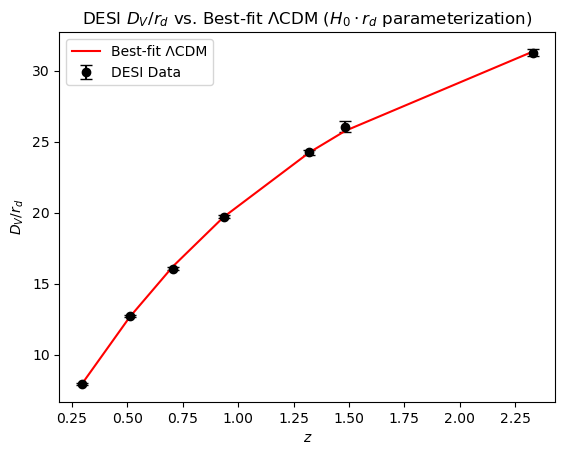

In [69]:
H0_fixed = 70.0
r_d_best = best_H0_times_r_d / H0_fixed
model_best = LambdaCDM(H0=H0_fixed, Omega_m=best_Omega_m, Omega_Lambda=best_Omega_Lambda, Omega_radiation=0)
distances_best = CosmologicalDistances(model_best.H)
D_V_model = np.array([distances_best.volume_distance(zi) for zi in z]) / r_d_best

plt.errorbar(z, D_V_obs, yerr=D_V_err, fmt='o', label='DESI Data', color='black', capsize=4)
plt.plot(z, D_V_model, 'r-', label='Best-fit ΛCDM')
plt.xlabel('$z$')
plt.ylabel(r'$D_V / r_d$')
plt.title('DESI $D_V / r_d$ vs. Best-fit ΛCDM ($H_0 \\cdot r_d$ parameterization)')
plt.legend()
plt.show()

### Note on Error Estimation

- The errors are estimated from the inverse Hessian (covariance matrix) at the minimum.

## Comparison with Literature: arXiv:2411.12020v1

<div style="background: #f6f8fa; border-left: 4px solid #0366d6; padding: 1em 1.5em; margin-bottom: 1em;">
<b>Paper Reference:</b> <a href="https://arxiv.org/abs/2411.12020v1" target="_blank">arXiv:2411.12020v1</a>  
<b>Table V, ΛCDM, DESI-only fit</b>
</div>

| ΛCDM              | My $χ^2$ minimization         | My MCMC sample    | Paper |
|-------------------|-------------------------------|-------------------|----------------------------|
| $H_0 \cdot r_d$   | $\text{10003.75} \pm \text{52.95}\,\text{km/s}$   | $9988.5347_{+191.0728}^{-190.0956}\,\text{km/s}$ | ~$\,11000 \,\text{km/s}$           |
| $\Omega_m$        | $\text{0.2696} \pm \text{0.0753}$           | $0.2684_{+0.0344}^{-0.0354}$       | $0.293 \pm 0.012$|
| $\Omega_k$        | $\text{0.1069} \pm \text{0.1748}$           | $0.1137_{+0.1270}^{-0.1201}$       | $0.26 \pm 0.41$ |
